# Cryptocurrency Price Prediction: Comprehensive Model Comparison

## Objective
This notebook compares the performance of five machine learning models for cryptocurrency price prediction:
1. **LSTM** (Long Short-Term Memory)
2. **GRU** (Gated Recurrent Unit)
3. **XGBoost** (Extreme Gradient Boosting)
4. **LightGBM** (Light Gradient Boosting Machine)
5. **Random Forest**

## 1. Import Libraries and Setup

In [1]:
!apt-get install -y libta-lib0 libta-lib0-dev
!pip install TA-Lib ta pandas_ta

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package libta-lib0
E: Unable to locate package libta-lib0-dev


In [2]:
# Check if running on Colab and mount Google Drive for persistent storage
try:
    from google.colab import drive
    import os
    drive.mount('/content/drive')
    SAVE_PATH = '.' # Change to your own save path
    os.makedirs(SAVE_PATH, exist_ok=True)
    print("✅ Google Drive mounted. Files will be saved persistently.")
    IS_COLAB = True
except:
    SAVE_PATH = './crypto_ml_saves/'
    os.makedirs(SAVE_PATH, exist_ok=True)
    IS_COLAB = False

# Optimize for faster training
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Reduce TensorFlow logging

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive mounted. Files will be saved persistently.


In [3]:
# Core libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Machine Learning - Traditional Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Machine Learning - Gradient Boosting
import xgboost as xgb
import lightgbm as lgb

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Technical Analysis
import talib
from ta import add_all_ta_features

# Utilities
import glob
import os
from datetime import datetime, timedelta
import time
from tqdm import tqdm
import gc

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Configure plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## 2. Data Loading and Exploration

### 2.1 Load Complete Dataset

In [4]:
def load_klines_dataset(data_directory, file_pattern="klines_*.csv"):
    """
    Load all klines CSV files from the dataset directory.

    Parameters:
    - data_directory: Path to directory containing CSV files
    - file_pattern: Pattern to match CSV files

    Returns:
    - Combined DataFrame with all data
    """
    print("🔄 Loading cryptocurrency klines dataset...")

    # Get all CSV files matching the pattern
    file_paths = glob.glob(os.path.join(data_directory, file_pattern))
    file_paths.sort()  # Ensure chronological order

    print(f"📁 Found {len(file_paths)} CSV files")

    if len(file_paths) == 0:
        raise FileNotFoundError(f"No files found matching pattern: {file_pattern}")

    # Load and combine all files
    dataframes = []
    for file_path in tqdm(file_paths, desc="Loading files"):
        try:
            df = pd.read_csv(file_path)
            dataframes.append(df)
        except Exception as e:
            print(f"⚠️ Error loading {file_path}: {e}")

    # Combine all dataframes
    combined_df = pd.concat(dataframes, ignore_index=True)

    print(f"✅ Dataset loaded successfully!")
    print(f"📊 Total records: {len(combined_df):,}")
    print(f"📅 Date range: {combined_df['open_time'].min()} to {combined_df['open_time'].max()}")

    return combined_df

# Load the dataset (adjust path as needed)
DATA_DIRECTORY = "."  # Current directory - adjust this to your data path
df = load_klines_dataset(DATA_DIRECTORY)

🔄 Loading cryptocurrency klines dataset...
📁 Found 2934 CSV files


Loading files: 100%|██████████| 2934/2934 [32:23<00:00,  1.51it/s]


✅ Dataset loaded successfully!
📊 Total records: 1,466,303
📅 Date range: 2017-08-17 04:00:00 to 2025-08-28 04:33:00


### 2.2 Data Preprocessing and Cleaning

In [5]:
def preprocess_klines_data(df):
    """
    Clean and preprocess the klines dataset.
    """
    print("🧹 Preprocessing data...")

    # Create a copy to avoid modifying original
    data = df.copy()

    # Convert timestamps to datetime
    data['open_time'] = pd.to_datetime(data['open_time'])
    data['close_time'] = pd.to_datetime(data['close_time'], unit='ms')

    # Sort by timestamp to ensure chronological order
    data = data.sort_values('open_time').reset_index(drop=True)

    # Remove duplicate timestamps (if any)
    initial_length = len(data)
    data = data.drop_duplicates(subset=['open_time'], keep='first')
    duplicates_removed = initial_length - len(data)
    if duplicates_removed > 0:
        print(f"🗑️ Removed {duplicates_removed} duplicate timestamps")

    # Check for missing values
    missing_values = data.isnull().sum()
    if missing_values.sum() > 0:
        print("⚠️ Missing values found:")
        print(missing_values[missing_values > 0])
        # Forward fill missing values for time series continuity
        data = data.fillna(method='ffill')
    else:
        print("✅ No missing values found")

    # Remove the 'ignore' column as it's not needed
    if 'ignore' in data.columns:
        data = data.drop('ignore', axis=1)

    # Verify OHLC logic (High >= Open, Low <= Close, etc.)
    invalid_ohlc = data[
        (data['high'] < data[['open', 'close']].max(axis=1)) |
        (data['low'] > data[['open', 'close']].min(axis=1))
    ]

    if len(invalid_ohlc) > 0:
        print(f"⚠️ Found {len(invalid_ohlc)} records with invalid OHLC logic")
        # Correct invalid OHLC data
        data.loc[data['high'] < data[['open', 'close']].max(axis=1), 'high'] = data[['open', 'close']].max(axis=1)
        data.loc[data['low'] > data[['open', 'close']].min(axis=1), 'low'] = data[['open', 'close']].min(axis=1)

    print(f"✅ Data preprocessing complete. Final dataset: {len(data):,} records")
    return data

# Preprocess the data
df_clean = preprocess_klines_data(df)

# Display basic information
print("\n📈 Dataset Overview:")
print(f"Shape: {df_clean.shape}")
print(f"Columns: {list(df_clean.columns)}")
print(f"Memory usage: {df_clean.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

🧹 Preprocessing data...
✅ No missing values found
✅ Data preprocessing complete. Final dataset: 1,466,303 records

📈 Dataset Overview:
Shape: (1466303, 12)
Columns: ['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'num_trades', 'taker_buy_base_volume', 'taker_buy_quote_volume', 'symbol']
Memory usage: 201.37 MB


### 2.3 Exploratory Data Analysis

🔍 Performing Exploratory Data Analysis...

📊 Basic Statistics:
               open          high           low         close        volume
count  1.466303e+06  1.466303e+06  1.466303e+06  1.466303e+06  1.466303e+06
mean   3.301690e+04  3.303048e+04  3.300323e+04  3.301689e+04  3.857266e+01
std    2.939097e+04  2.939879e+04  2.938319e+04  2.939100e+04  7.258009e+01
min    3.030010e+03  3.030020e+03  3.030000e+03  3.030000e+03  0.000000e+00
25%    8.918045e+03  8.924150e+03  8.911985e+03  8.918425e+03  8.038210e+00
50%    2.338316e+04  2.339181e+04  2.337488e+04  2.338315e+04  1.741292e+01
75%    4.856000e+04  4.859193e+04  4.852843e+04  4.855987e+04  3.880755e+01
max    1.244477e+05  1.244740e+05  1.242840e+05  1.244477e+05  3.971225e+03

💰 Price Analysis:
Starting price: $4,261.48
Ending price: $112,363.11
Total return: 2536.72%
Daily volatility: 0.0018
Annualized volatility: 126.98%


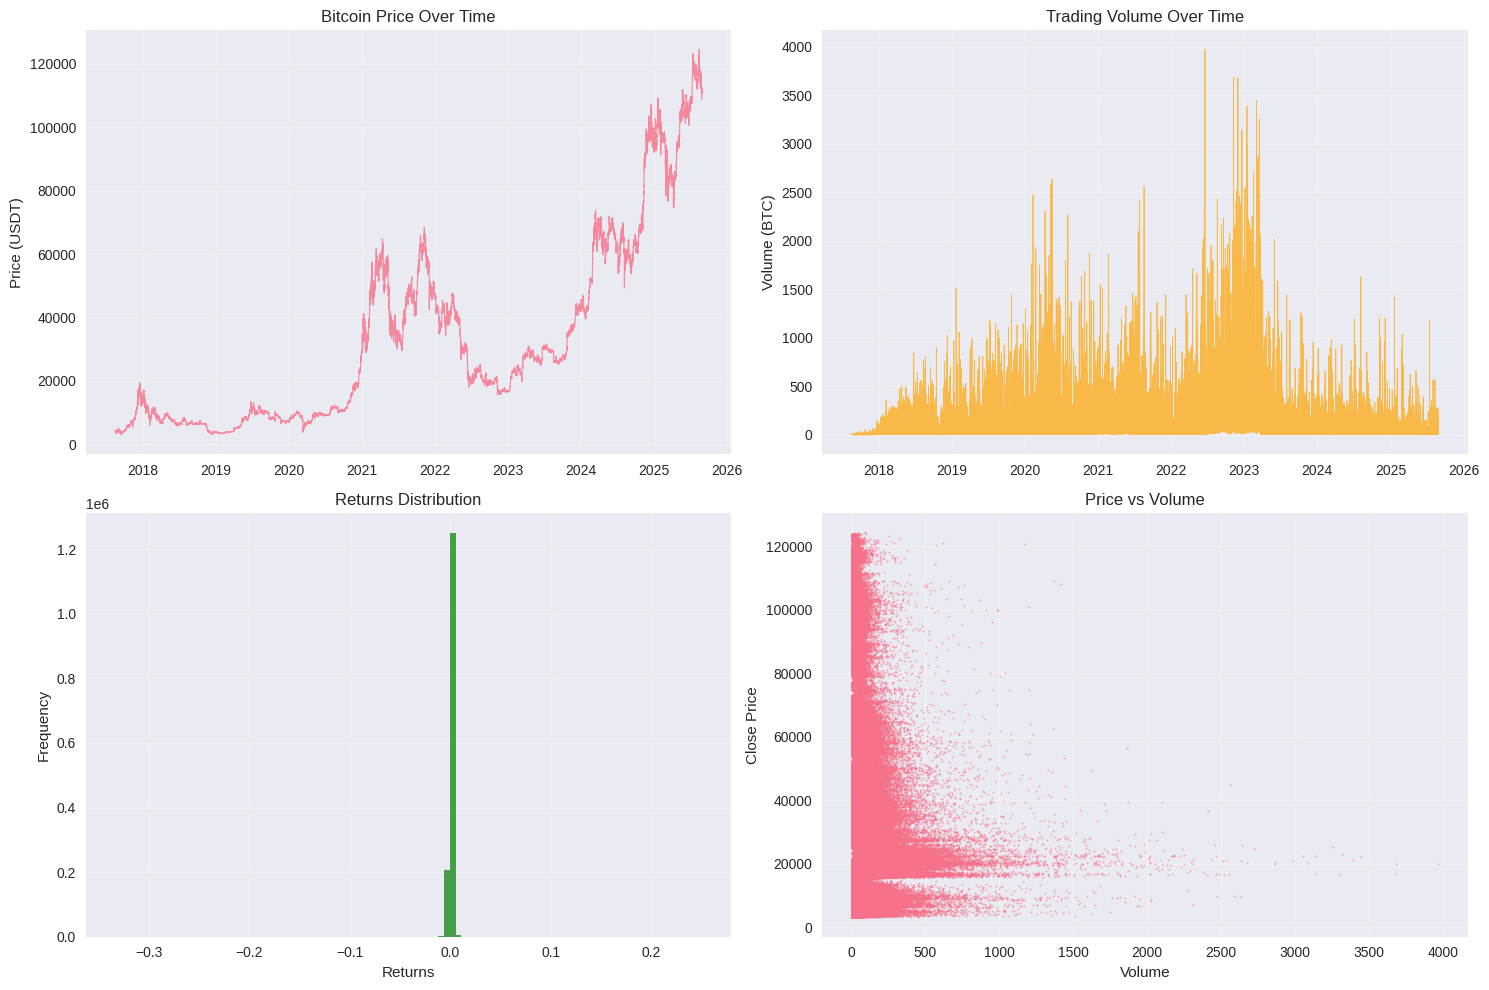

In [6]:
def perform_eda(data):
    """
    Perform comprehensive exploratory data analysis.
    """
    print("🔍 Performing Exploratory Data Analysis...")

    # Basic statistics
    print("\n📊 Basic Statistics:")
    print(data[['open', 'high', 'low', 'close', 'volume']].describe())

    # Price trend analysis
    print(f"\n💰 Price Analysis:")
    print(f"Starting price: ${data['open'].iloc[0]:,.2f}")
    print(f"Ending price: ${data['close'].iloc[-1]:,.2f}")
    total_return = ((data['close'].iloc[-1] / data['open'].iloc[0]) - 1) * 100
    print(f"Total return: {total_return:.2f}%")

    # Volatility analysis
    data['returns'] = data['close'].pct_change()
    daily_volatility = data['returns'].std()
    annualized_volatility = daily_volatility * np.sqrt(365 * 24 * 60)  # Minute data to annual
    print(f"Daily volatility: {daily_volatility:.4f}")
    print(f"Annualized volatility: {annualized_volatility:.2%}")

    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Price chart
    axes[0, 0].plot(data['open_time'], data['close'], linewidth=0.8, alpha=0.8)
    axes[0, 0].set_title('Bitcoin Price Over Time')
    axes[0, 0].set_ylabel('Price (USDT)')
    axes[0, 0].grid(True, alpha=0.3)

    # Volume chart
    axes[0, 1].plot(data['open_time'], data['volume'], color='orange', linewidth=0.6, alpha=0.7)
    axes[0, 1].set_title('Trading Volume Over Time')
    axes[0, 1].set_ylabel('Volume (BTC)')
    axes[0, 1].grid(True, alpha=0.3)

    # Returns distribution
    axes[1, 0].hist(data['returns'].dropna(), bins=100, alpha=0.7, color='green')
    axes[1, 0].set_title('Returns Distribution')
    axes[1, 0].set_xlabel('Returns')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].grid(True, alpha=0.3)

    # Price vs Volume correlation
    axes[1, 1].scatter(data['volume'], data['close'], alpha=0.5, s=1)
    axes[1, 1].set_title('Price vs Volume')
    axes[1, 1].set_xlabel('Volume')
    axes[1, 1].set_ylabel('Close Price')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return data

# Perform EDA
df_analyzed = perform_eda(df_clean)

## 3. Feature Engineering

### 3.1 Technical Indicators

In [7]:
def create_technical_indicators(data):
    """
    Create comprehensive technical indicators for improved prediction accuracy.
    """
    print("⚙️ Creating technical indicators...")

    # Create a copy for feature engineering
    df_features = data.copy()

    # Price-based features
    df_features['price_change'] = df_features['close'] - df_features['open']
    df_features['price_change_pct'] = df_features['close'].pct_change()
    df_features['high_low_pct'] = (df_features['high'] - df_features['low']) / df_features['close']
    df_features['open_close_pct'] = (df_features['close'] - df_features['open']) / df_features['open']

    # Moving averages
    for window in [5, 10, 20, 50]:
        df_features[f'sma_{window}'] = df_features['close'].rolling(window=window).mean()
        df_features[f'ema_{window}'] = df_features['close'].ewm(span=window).mean()

    # RSI (Relative Strength Index)
    def calculate_rsi(prices, window=14):
        delta = prices.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
        rs = gain / loss
        return 100 - (100 / (1 + rs))

    df_features['rsi'] = calculate_rsi(df_features['close'])

    # MACD (Moving Average Convergence Divergence)
    ema12 = df_features['close'].ewm(span=12).mean()
    ema26 = df_features['close'].ewm(span=26).mean()
    df_features['macd'] = ema12 - ema26
    df_features['macd_signal'] = df_features['macd'].ewm(span=9).mean()
    df_features['macd_histogram'] = df_features['macd'] - df_features['macd_signal']

    # Bollinger Bands
    bb_window = 20
    bb_std = 2
    bb_middle = df_features['close'].rolling(window=bb_window).mean()
    bb_std_dev = df_features['close'].rolling(window=bb_window).std()
    df_features['bb_upper'] = bb_middle + (bb_std_dev * bb_std)
    df_features['bb_lower'] = bb_middle - (bb_std_dev * bb_std)
    df_features['bb_position'] = (df_features['close'] - df_features['bb_lower']) / (df_features['bb_upper'] - df_features['bb_lower'])

    # Volume indicators
    df_features['volume_sma_10'] = df_features['volume'].rolling(window=10).mean()
    df_features['volume_ratio'] = df_features['volume'] / df_features['volume_sma_10']
    df_features['price_volume'] = df_features['close'] * df_features['volume']

    # Momentum indicators
    df_features['momentum'] = df_features['close'] / df_features['close'].shift(4) - 1
    df_features['rate_of_change'] = df_features['close'].pct_change(periods=5)

    # Volatility indicators
    df_features['volatility'] = df_features['close'].rolling(window=10).std()
    df_features['atr'] = (df_features[['high', 'low', 'close']].max(axis=1) -
                         df_features[['high', 'low', 'close']].min(axis=1)).rolling(window=14).mean()

    # Time-based features
    df_features['hour'] = df_features['open_time'].dt.hour
    df_features['day_of_week'] = df_features['open_time'].dt.dayofweek
    df_features['is_weekend'] = df_features['day_of_week'].isin([5, 6]).astype(int)

    # Lag features (previous time step values)
    for lag in [1, 2, 3, 5, 10]:
        df_features[f'close_lag_{lag}'] = df_features['close'].shift(lag)
        df_features[f'volume_lag_{lag}'] = df_features['volume'].shift(lag)
        df_features[f'returns_lag_{lag}'] = df_features['price_change_pct'].shift(lag)

    # Rolling statistics
    for window in [5, 10, 20]:
        df_features[f'close_rolling_mean_{window}'] = df_features['close'].rolling(window=window).mean()
        df_features[f'close_rolling_std_{window}'] = df_features['close'].rolling(window=window).std()
        df_features[f'volume_rolling_mean_{window}'] = df_features['volume'].rolling(window=window).mean()

    print(f"✅ Created {len(df_features.columns) - len(data.columns)} new features")
    print(f"Total features: {len(df_features.columns)}")

    return df_features

# Create technical indicators
df_with_features = create_technical_indicators(df_analyzed)

# Remove rows with NaN values (from rolling calculations)
df_final = df_with_features.dropna().reset_index(drop=True)
print(f"📊 Final dataset shape after feature engineering: {df_final.shape}")

⚙️ Creating technical indicators...
✅ Created 53 new features
Total features: 66
📊 Final dataset shape after feature engineering: (1465396, 66)


### 3.2 Target Variable and Feature Selection

In [8]:
def prepare_model_data(data, target_column='close', prediction_horizon=1):
    """
    Prepare data for machine learning models.

    Parameters:
    - data: DataFrame with features
    - target_column: Column to predict
    - prediction_horizon: How many steps ahead to predict
    """
    print(f"🎯 Preparing data for {prediction_horizon}-step ahead prediction...")

    # Create target variable (future price)
    data = data.copy()
    data['target'] = data[target_column].shift(-prediction_horizon)

    # Remove rows where target is NaN
    data = data.dropna().reset_index(drop=True)

    # Define feature columns (exclude non-predictive columns)
    exclude_columns = ['open_time', 'close_time', 'symbol', 'target']
    feature_columns = [col for col in data.columns if col not in exclude_columns]

    print(f"📋 Feature columns: {len(feature_columns)}")
    print(f"🎯 Target column: {target_column} (shifted by {prediction_horizon})")
    print(f"📊 Final dataset size: {len(data)} samples")

    return data, feature_columns

# Prepare data for modeling
df_model_ready, feature_cols = prepare_model_data(df_final, target_column='close', prediction_horizon=1)

# Display feature importance preview
print("\n🔍 Feature Preview:")
print("Numerical features:", [col for col in feature_cols if df_model_ready[col].dtype in ['float64', 'int64']][:10])
print("Total feature count:", len(feature_cols))

🎯 Preparing data for 1-step ahead prediction...
📋 Feature columns: 63
🎯 Target column: close (shifted by 1)
📊 Final dataset size: 1465395 samples

🔍 Feature Preview:
Numerical features: ['open', 'high', 'low', 'close', 'volume', 'quote_asset_volume', 'num_trades', 'taker_buy_base_volume', 'taker_buy_quote_volume', 'returns']
Total feature count: 63


## 4. Data Splitting and Scaling

### 4.1 Time Series Split

In [9]:
def create_time_series_splits(data, feature_columns, target_column='target',
                             train_ratio=0.7, validation_ratio=0.15, test_ratio=0.15):
    """
    Create time-series aware train/validation/test splits.
    """
    print("✂️ Creating time series splits...")

    # Ensure ratios sum to 1
    assert abs(train_ratio + validation_ratio + test_ratio - 1.0) < 1e-6

    n_samples = len(data)
    train_end = int(n_samples * train_ratio)
    val_end = int(n_samples * (train_ratio + validation_ratio))

    # Create splits
    train_data = data.iloc[:train_end].copy()
    val_data = data.iloc[train_end:val_end].copy()
    test_data = data.iloc[val_end:].copy()

    # Extract features and targets
    X_train = train_data[feature_columns].values
    y_train = train_data[target_column].values

    X_val = val_data[feature_columns].values
    y_val = val_data[target_column].values

    X_test = test_data[feature_columns].values
    y_test = test_data[target_column].values

    print(f"📊 Data splits:")
    print(f"   Training: {len(X_train):,} samples ({train_ratio:.1%})")
    print(f"   Validation: {len(X_val):,} samples ({validation_ratio:.1%})")
    print(f"   Testing: {len(X_test):,} samples ({test_ratio:.1%})")

    return (X_train, y_train), (X_val, y_val), (X_test, y_test), (train_data, val_data, test_data)

# Create splits
(X_train, y_train), (X_val, y_val), (X_test, y_test), (train_df, val_df, test_df) = create_time_series_splits(
    df_model_ready, feature_cols, target_column='target'
)

✂️ Creating time series splits...
📊 Data splits:
   Training: 1,025,776 samples (70.0%)
   Validation: 219,809 samples (15.0%)
   Testing: 219,810 samples (15.0%)


### 4.2 Feature Scaling and Data Cleaning

In [10]:
def clean_and_validate_data(X_train, X_val, X_test, y_train, y_val, y_test):
    """
    Clean data by handling infinite values, outliers, and missing data.
    """
    print("🧹 Cleaning and validating data...")

    # Convert to DataFrames for easier manipulation
    X_train_df = pd.DataFrame(X_train)
    X_val_df = pd.DataFrame(X_val)
    X_test_df = pd.DataFrame(X_test)

    # Check for infinite values
    def check_infinite_values(df, name):
        inf_count = np.isinf(df.values).sum()
        if inf_count > 0:
            print(f"   ⚠️ Found {inf_count} infinite values in {name}")
        return inf_count

    # Check for NaN values
    def check_nan_values(df, name):
        nan_count = np.isnan(df.values).sum()
        if nan_count > 0:
            print(f"   ⚠️ Found {nan_count} NaN values in {name}")
        return nan_count

    # Check all datasets
    check_infinite_values(X_train_df, "X_train")
    check_infinite_values(X_val_df, "X_val")
    check_infinite_values(X_test_df, "X_test")

    check_nan_values(X_train_df, "X_train")
    check_nan_values(X_val_df, "X_val")
    check_nan_values(X_test_df, "X_test")

    # Replace infinite values with NaN first
    X_train_df = X_train_df.replace([np.inf, -np.inf], np.nan)
    X_val_df = X_val_df.replace([np.inf, -np.inf], np.nan)
    X_test_df = X_test_df.replace([np.inf, -np.inf], np.nan)

    # Handle NaN values by forward filling then backward filling
    X_train_df = X_train_df.fillna(method='ffill').fillna(method='bfill')
    X_val_df = X_val_df.fillna(method='ffill').fillna(method='bfill')
    X_test_df = X_test_df.fillna(method='ffill').fillna(method='bfill')

    # If still NaN values remain, fill with column means from training data
    train_means = X_train_df.mean()
    X_train_df = X_train_df.fillna(train_means)
    X_val_df = X_val_df.fillna(train_means)
    X_test_df = X_test_df.fillna(train_means)

    # Remove extreme outliers (beyond 5 standard deviations)
    def cap_outliers(df, reference_df=None):
        if reference_df is None:
            reference_df = df

        # Calculate bounds based on reference dataset (training data)
        means = reference_df.mean()
        stds = reference_df.std()

        lower_bounds = means - 5 * stds
        upper_bounds = means + 5 * stds

        # Cap outliers
        for col in df.columns:
            df[col] = np.clip(df[col], lower_bounds[col], upper_bounds[col])

        return df

    X_train_df = cap_outliers(X_train_df)
    X_val_df = cap_outliers(X_val_df, X_train_df)  # Use training stats as reference
    X_test_df = cap_outliers(X_test_df, X_train_df)

    # Final validation
    print("✅ Data cleaning complete!")
    print(f"   Training set - Inf: {np.isinf(X_train_df.values).sum()}, NaN: {np.isnan(X_train_df.values).sum()}")
    print(f"   Validation set - Inf: {np.isinf(X_val_df.values).sum()}, NaN: {np.isnan(X_val_df.values).sum()}")
    print(f"   Test set - Inf: {np.isinf(X_test_df.values).sum()}, NaN: {np.isnan(X_test_df.values).sum()}")

    return X_train_df.values, X_val_df.values, X_test_df.values, y_train, y_val, y_test

def scale_features(X_train, X_val, X_test, scaling_method='standard'):
    """
    Scale features using specified method with robust error handling.
    """
    print(f"⚖️ Scaling features using {scaling_method} scaling...")

    # Additional safety check before scaling
    if np.any(np.isinf(X_train)) or np.any(np.isnan(X_train)):
        raise ValueError("Training data still contains infinite or NaN values after cleaning")

    if scaling_method == 'standard':
        scaler = StandardScaler()
    elif scaling_method == 'minmax':
        scaler = MinMaxScaler()
    elif scaling_method == 'robust':
        from sklearn.preprocessing import RobustScaler
        scaler = RobustScaler()  # Less sensitive to outliers
    else:
        raise ValueError("scaling_method must be 'standard', 'minmax', or 'robust'")

    try:
        # Fit scaler on training data only
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        X_test_scaled = scaler.transform(X_test)

        # Final validation of scaled data
        if np.any(np.isinf(X_train_scaled)) or np.any(np.isnan(X_train_scaled)):
            print("⚠️ Warning: Scaled data contains infinite or NaN values")
            # Use robust scaling as fallback
            print("   Switching to RobustScaler as fallback...")
            from sklearn.preprocessing import RobustScaler
            scaler = RobustScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_val_scaled = scaler.transform(X_val)
            X_test_scaled = scaler.transform(X_test)

    except Exception as e:
        print(f"❌ Error during scaling: {e}")
        print("   Using RobustScaler as fallback...")
        from sklearn.preprocessing import RobustScaler
        scaler = RobustScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        X_test_scaled = scaler.transform(X_test)

    print(f"✅ Feature scaling complete")
    print(f"   Training set shape: {X_train_scaled.shape}")
    print(f"   Validation set shape: {X_val_scaled.shape}")
    print(f"   Test set shape: {X_test_scaled.shape}")
    print(f"   Scaling method used: {type(scaler).__name__}")

    return X_train_scaled, X_val_scaled, X_test_scaled, scaler

# Clean and validate data first
X_train_clean, X_val_clean, X_test_clean, y_train, y_val, y_test = clean_and_validate_data(
    X_train, X_val, X_test, y_train, y_val, y_test
)

# Scale features for traditional ML models
X_train_scaled, X_val_scaled, X_test_scaled, feature_scaler = scale_features(
    X_train_clean, X_val_clean, X_test_clean, scaling_method='standard'
)

# Scale target for neural networks (helps with training stability)
def scale_target_safely(y_train, y_val, y_test):
    """
    Scale target values with safety checks.
    """
    print("🎯 Scaling target values...")

    # Check for infinite or NaN values in targets
    if np.any(np.isinf(y_train)) or np.any(np.isnan(y_train)):
        print("⚠️ Target values contain infinite or NaN values, cleaning...")
        y_train = np.nan_to_num(y_train, nan=np.nanmean(y_train),
                               posinf=np.nanmax(y_train[np.isfinite(y_train)]),
                               neginf=np.nanmin(y_train[np.isfinite(y_train)]))

    target_scaler = StandardScaler()
    y_train_scaled = target_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
    y_val_scaled = target_scaler.transform(y_val.reshape(-1, 1)).flatten()
    y_test_scaled = target_scaler.transform(y_test.reshape(-1, 1)).flatten()

    print("✅ Target scaling complete")
    return y_train_scaled, y_val_scaled, y_test_scaled, target_scaler

y_train_scaled, y_val_scaled, y_test_scaled, target_scaler = scale_target_safely(
    y_train, y_val, y_test
)

🧹 Cleaning and validating data...
   ⚠️ Found 57 infinite values in X_val
   ⚠️ Found 7 infinite values in X_test
✅ Data cleaning complete!
   Training set - Inf: 0, NaN: 0
   Validation set - Inf: 0, NaN: 0
   Test set - Inf: 0, NaN: 0
⚖️ Scaling features using standard scaling...
✅ Feature scaling complete
   Training set shape: (1025776, 63)
   Validation set shape: (219809, 63)
   Test set shape: (219810, 63)
   Scaling method used: StandardScaler
🎯 Scaling target values...
✅ Target scaling complete


## 5. Model Implementation and Training

In [13]:
def save_model(model, model_name, metadata=None):
    """Save model with metadata."""
    model_path = os.path.join(SAVE_PATH, f'{model_name}_model')

    if hasattr(model, 'save'):  # Keras models
        model.save(f"{model_path}.h5")
    else:  # Scikit-learn and other models
        import pickle
        with open(f"{model_path}.pkl", 'wb') as f:
            pickle.dump(model, f)

    # Save metadata
    if metadata:
        import json
        with open(f"{model_path}_metadata.json", 'w') as f:
            json.dump(metadata, f)

    print(f"💾 Saved model: {model_name}")

def load_model(model_name):
    """Load model if exists."""
    model_path = os.path.join(SAVE_PATH, f'{model_name}_model')

    # Try loading Keras model first
    if os.path.exists(f"{model_path}.h5"):
        from tensorflow.keras.models import load_model
        model = load_model(f"{model_path}.h5")
        print(f"📂 Loaded Keras model: {model_name}")
        return model

    # Try loading pickle model
    elif os.path.exists(f"{model_path}.pkl"):
        import pickle
        with open(f"{model_path}.pkl", 'rb') as f:
            model = pickle.load(f)
        print(f"📂 Loaded pickle model: {model_name}")
        return model

    print(f"❌ Model not found: {model_name}")
    return None

def load_or_create_scaling(X_train, X_val, X_test, y_train, y_val, y_test):
    """Load scaling if exists, otherwise create new."""
    scaler_path = os.path.join(SAVE_PATH, 'feature_scaler.pkl')
    target_scaler_path = os.path.join(SAVE_PATH, 'target_scaler.pkl')

    if os.path.exists(scaler_path) and os.path.exists(target_scaler_path):
        print("📂 Loading existing scalers...")
        import pickle

        with open(scaler_path, 'rb') as f:
            feature_scaler = pickle.load(f)
        with open(target_scaler_path, 'rb') as f:
            target_scaler = pickle.load(f)

        # Try to load scaled data
        try:
            X_train_scaled = np.load(os.path.join(SAVE_PATH, 'X_train_scaled.npy'))
            X_val_scaled = np.load(os.path.join(SAVE_PATH, 'X_val_scaled.npy'))
            X_test_scaled = np.load(os.path.join(SAVE_PATH, 'X_test_scaled.npy'))
            y_train_scaled = np.load(os.path.join(SAVE_PATH, 'y_train_scaled.npy'))
            y_val_scaled = np.load(os.path.join(SAVE_PATH, 'y_val_scaled.npy'))
            y_test_scaled = np.load(os.path.join(SAVE_PATH, 'y_test_scaled.npy'))

            print("✅ Loaded existing scaling")
            return (X_train_scaled, X_val_scaled, X_test_scaled,
                    y_train_scaled, y_val_scaled, y_test_scaled,
                    feature_scaler, target_scaler)
        except Exception as e:
            print(f"⚠️ Could not load scaled data: {e}")
            print("Creating new scaling...")

    print("⚖️ Creating new scaling...")

    # Import the cleaning functions from section 4.2
    def clean_and_validate_data(X_train, X_val, X_test, y_train, y_val, y_test):
        """Clean data by handling infinite values, outliers, and missing data."""
        print("🧹 Cleaning and validating data...")

        # Convert to DataFrames for easier manipulation
        X_train_df = pd.DataFrame(X_train)
        X_val_df = pd.DataFrame(X_val)
        X_test_df = pd.DataFrame(X_test)

        # Replace infinite values with NaN first
        X_train_df = X_train_df.replace([np.inf, -np.inf], np.nan)
        X_val_df = X_val_df.replace([np.inf, -np.inf], np.nan)
        X_test_df = X_test_df.replace([np.inf, -np.inf], np.nan)

        # Handle NaN values by forward filling then backward filling
        X_train_df = X_train_df.fillna(method='ffill').fillna(method='bfill')
        X_val_df = X_val_df.fillna(method='ffill').fillna(method='bfill')
        X_test_df = X_test_df.fillna(method='ffill').fillna(method='bfill')

        # If still NaN values remain, fill with column means from training data
        train_means = X_train_df.mean()
        X_train_df = X_train_df.fillna(train_means)
        X_val_df = X_val_df.fillna(train_means)
        X_test_df = X_test_df.fillna(train_means)

        # Remove extreme outliers (beyond 5 standard deviations)
        def cap_outliers(df, reference_df=None):
            if reference_df is None:
                reference_df = df

            means = reference_df.mean()
            stds = reference_df.std()

            lower_bounds = means - 5 * stds
            upper_bounds = means + 5 * stds

            for col in df.columns:
                df[col] = np.clip(df[col], lower_bounds[col], upper_bounds[col])

            return df

        X_train_df = cap_outliers(X_train_df)
        X_val_df = cap_outliers(X_val_df, X_train_df)
        X_test_df = cap_outliers(X_test_df, X_train_df)

        print("✅ Data cleaning complete!")
        return X_train_df.values, X_val_df.values, X_test_df.values, y_train, y_val, y_test

    def scale_features(X_train, X_val, X_test, scaling_method='standard'):
        """Scale features using specified method with robust error handling."""
        print(f"⚖️ Scaling features using {scaling_method} scaling...")

        if scaling_method == 'standard':
            scaler = StandardScaler()
        elif scaling_method == 'robust':
            from sklearn.preprocessing import RobustScaler
            scaler = RobustScaler()
        else:
            scaler = StandardScaler()

        try:
            X_train_scaled = scaler.fit_transform(X_train)
            X_val_scaled = scaler.transform(X_val)
            X_test_scaled = scaler.transform(X_test)

            if np.any(np.isinf(X_train_scaled)) or np.any(np.isnan(X_train_scaled)):
                print("   Switching to RobustScaler as fallback...")
                from sklearn.preprocessing import RobustScaler
                scaler = RobustScaler()
                X_train_scaled = scaler.fit_transform(X_train)
                X_val_scaled = scaler.transform(X_val)
                X_test_scaled = scaler.transform(X_test)

        except Exception as e:
            print(f"   Error during scaling: {e}")
            print("   Using RobustScaler as fallback...")
            from sklearn.preprocessing import RobustScaler
            scaler = RobustScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_val_scaled = scaler.transform(X_val)
            X_test_scaled = scaler.transform(X_test)

        print(f"✅ Feature scaling complete using {type(scaler).__name__}")
        return X_train_scaled, X_val_scaled, X_test_scaled, scaler

    def scale_target_safely(y_train, y_val, y_test):
        """Scale target values with safety checks."""
        print("🎯 Scaling target values...")

        if np.any(np.isinf(y_train)) or np.any(np.isnan(y_train)):
            print("⚠️ Target values contain infinite or NaN values, cleaning...")
            y_train = np.nan_to_num(y_train, nan=np.nanmean(y_train),
                                   posinf=np.nanmax(y_train[np.isfinite(y_train)]),
                                   neginf=np.nanmin(y_train[np.isfinite(y_train)]))

        target_scaler = StandardScaler()
        y_train_scaled = target_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
        y_val_scaled = target_scaler.transform(y_val.reshape(-1, 1)).flatten()
        y_test_scaled = target_scaler.transform(y_test.reshape(-1, 1)).flatten()

        print("✅ Target scaling complete")
        return y_train_scaled, y_val_scaled, y_test_scaled, target_scaler

    # Clean and scale the data
    X_train_clean, X_val_clean, X_test_clean, y_train, y_val, y_test = clean_and_validate_data(
        X_train, X_val, X_test, y_train, y_val, y_test
    )

    X_train_scaled, X_val_scaled, X_test_scaled, feature_scaler = scale_features(
        X_train_clean, X_val_clean, X_test_clean, scaling_method='robust'
    )

    y_train_scaled, y_val_scaled, y_test_scaled, target_scaler = scale_target_safely(
        y_train, y_val, y_test
    )

    # Save scalers and scaled data
    import pickle
    with open(scaler_path, 'wb') as f:
        pickle.dump(feature_scaler, f)
    with open(target_scaler_path, 'wb') as f:
        pickle.dump(target_scaler, f)

    np.save(os.path.join(SAVE_PATH, 'X_train_scaled.npy'), X_train_scaled)
    np.save(os.path.join(SAVE_PATH, 'X_val_scaled.npy'), X_val_scaled)
    np.save(os.path.join(SAVE_PATH, 'X_test_scaled.npy'), X_test_scaled)
    np.save(os.path.join(SAVE_PATH, 'y_train_scaled.npy'), y_train_scaled)
    np.save(os.path.join(SAVE_PATH, 'y_val_scaled.npy'), y_val_scaled)
    np.save(os.path.join(SAVE_PATH, 'y_test_scaled.npy'), y_test_scaled)

    print("💾 Saved scaling data")
    return (X_train_scaled, X_val_scaled, X_test_scaled,
            y_train_scaled, y_val_scaled, y_test_scaled,
            feature_scaler, target_scaler)

# Fast model training functions (reduced complexity for speed)
def train_random_forest_fast(X_train, y_train, X_val, y_val):
    """Train Random Forest with faster settings."""
    print("🌲 Training Random Forest (Fast Mode)...")

    # Check if model exists
    model = load_model('random_forest')
    if model is not None:
        return model

    # Single configuration for speed
    model = RandomForestRegressor(
        n_estimators=50,  # Reduced from 100+
        max_depth=10,
        min_samples_split=5,
        random_state=42,
        n_jobs=-1  # Use all CPU cores
    )

    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time

    val_pred = model.predict(X_val)
    val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))

    print(f"✅ Random Forest - RMSE: {val_rmse:.4f}, Time: {train_time:.2f}s")

    # Save model
    save_model(model, 'random_forest', {'rmse': val_rmse, 'train_time': train_time})
    return model

def train_xgboost_fast(X_train, y_train, X_val, y_val):
    """Train XGBoost with faster settings."""
    print("🚀 Training XGBoost (Fast Mode)...")

    model = load_model('xgboost')
    if model is not None:
        return model

    # Single configuration for speed
    model = xgb.XGBRegressor(
        n_estimators=50,  # Reduced
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        random_state=42,
        n_jobs=-1,
        verbosity=0
    )

    start_time = time.time()

    # Try the newer XGBoost API first, fall back to older API if needed
    try:
        # Newer XGBoost API (>=1.6.0)
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            callbacks=[xgb.callback.EarlyStopping(rounds=10, save_best=True)],
            verbose=False
        )
    except (TypeError, AttributeError):
        try:
            # Older XGBoost API
            model.fit(
                X_train, y_train,
                eval_set=[(X_val, y_val)],
                early_stopping_rounds=10,
                verbose=False
            )
        except TypeError:
            # Fallback - train without early stopping
            print("   Warning: Early stopping not supported, training without it")
            model.fit(X_train, y_train, verbose=False)

    train_time = time.time() - start_time

    val_pred = model.predict(X_val)
    val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))

    print(f"✅ XGBoost - RMSE: {val_rmse:.4f}, Time: {train_time:.2f}s")

    save_model(model, 'xgboost', {'rmse': val_rmse, 'train_time': train_time})
    return model

def train_lightgbm_fast(X_train, y_train, X_val, y_val):
    """Train LightGBM with faster settings."""
    print("💡 Training LightGBM (Fast Mode)...")

    model = load_model('lightgbm')
    if model is not None:
        return model

    model = lgb.LGBMRegressor(
        n_estimators=50,  # Reduced
        num_leaves=31,
        learning_rate=0.1,
        subsample=0.8,
        random_state=42,
        n_jobs=-1,
        verbosity=-1
    )

    start_time = time.time()
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        callbacks=[lgb.early_stopping(10), lgb.log_evaluation(0)]
    )
    train_time = time.time() - start_time

    val_pred = model.predict(X_val)
    val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))

    print(f"✅ LightGBM - RMSE: {val_rmse:.4f}, Time: {train_time:.2f}s")

    save_model(model, 'lightgbm', {'rmse': val_rmse, 'train_time': train_time})
    return model

def create_sequences_fast(X, y, sequence_length=30):  # Reduced from 60
    """Create sequences for neural networks."""
    X_seq, y_seq = [], []
    step = 2  # Skip every other sequence for speed
    for i in range(0, len(X) - sequence_length, step):
        X_seq.append(X[i:(i + sequence_length)])
        y_seq.append(y[i + sequence_length])
    return np.array(X_seq), np.array(y_seq)

def train_lstm_fast(X_train, y_train, X_val, y_val, sequence_length=30):
    """Train LSTM with faster settings."""
    print("🧠 Training LSTM (Fast Mode)...")

    model = load_model('lstm')
    if model is not None:
        # Still need to create sequences for evaluation
        X_train_seq, y_train_seq = create_sequences_fast(X_train, y_train, sequence_length)
        X_val_seq, y_val_seq = create_sequences_fast(X_val, y_val, sequence_length)
        return model, None, (X_train_seq, y_train_seq, X_val_seq, y_val_seq)

    # Create sequences
    X_train_seq, y_train_seq = create_sequences_fast(X_train, y_train, sequence_length)
    X_val_seq, y_val_seq = create_sequences_fast(X_val, y_val, sequence_length)

    print(f"   Sequence shape - Train: {X_train_seq.shape}, Val: {X_val_seq.shape}")

    # Smaller LSTM model for speed
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(sequence_length, X_train.shape[1])),  # Reduced units
        Dropout(0.2),

        LSTM(25, return_sequences=False),  # Reduced units
        Dropout(0.2),

        Dense(1)
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),  # More aggressive
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)
    ]

    start_time = time.time()
    history = model.fit(
        X_train_seq, y_train_seq,
        validation_data=(X_val_seq, y_val_seq),
        epochs=20,  # Reduced from 100
        batch_size=64,  # Larger batch size
        callbacks=callbacks,
        verbose=1
    )
    train_time = time.time() - start_time

    print(f"✅ LSTM training complete - Time: {train_time:.2f}s")

    save_model(model, 'lstm', {'train_time': train_time})
    return model, history, (X_train_seq, y_train_seq, X_val_seq, y_val_seq)

def train_gru_fast(X_train, y_train, X_val, y_val, sequence_length=30):
    """Train GRU with faster settings."""
    print("🔄 Training GRU (Fast Mode)...")

    model = load_model('gru')
    if model is not None:
        X_train_seq, y_train_seq = create_sequences_fast(X_train, y_train, sequence_length)
        X_val_seq, y_val_seq = create_sequences_fast(X_val, y_val, sequence_length)
        return model, None, (X_train_seq, y_train_seq, X_val_seq, y_val_seq)

    # Create sequences
    X_train_seq, y_train_seq = create_sequences_fast(X_train, y_train, sequence_length)
    X_val_seq, y_val_seq = create_sequences_fast(X_val, y_val, sequence_length)

    print(f"   Sequence shape - Train: {X_train_seq.shape}, Val: {X_val_seq.shape}")

    # Smaller GRU model for speed
    model = Sequential([
        GRU(50, return_sequences=True, input_shape=(sequence_length, X_train.shape[1])),
        Dropout(0.2),

        GRU(25, return_sequences=False),
        Dropout(0.2),

        Dense(1)
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)
    ]

    start_time = time.time()
    history = model.fit(
        X_train_seq, y_train_seq,
        validation_data=(X_val_seq, y_val_seq),
        epochs=20,  # Reduced
        batch_size=64,
        callbacks=callbacks,
        verbose=1
    )
    train_time = time.time() - start_time

    print(f"✅ GRU training complete - Time: {train_time:.2f}s")

    save_model(model, 'gru', {'train_time': train_time})
    return model, history, (X_train_seq, y_train_seq, X_val_seq, y_val_seq)

# Load or create scaling (now properly passing the data variables)
(X_train_scaled, X_val_scaled, X_test_scaled,
 y_train_scaled, y_val_scaled, y_test_scaled,
 feature_scaler, target_scaler) = load_or_create_scaling(X_train, X_val, X_test, y_train, y_val, y_test)

print("\n🚀 Starting fast model training...")
print("⚡ Models will be saved and loaded automatically to save time")

# Train all models (fast versions)
rf_model = train_random_forest_fast(X_train_scaled, y_train, X_val_scaled, y_val)
xgb_model = train_xgboost_fast(X_train_scaled, y_train, X_val_scaled, y_val)
lgb_model = train_lightgbm_fast(X_train_scaled, y_train, X_val_scaled, y_val)
lstm_model, lstm_history, lstm_sequences = train_lstm_fast(X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled)
gru_model, gru_history, gru_sequences = train_gru_fast(X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled)

print("✅ All models trained/loaded successfully!")

📂 Loading existing scalers...
✅ Loaded existing scaling

🚀 Starting fast model training...
⚡ Models will be saved and loaded automatically to save time
🌲 Training Random Forest (Fast Mode)...
📂 Loaded pickle model: random_forest
🚀 Training XGBoost (Fast Mode)...
❌ Model not found: xgboost
✅ XGBoost - RMSE: 1502.2010, Time: 5.54s
💾 Saved model: xgboost
💡 Training LightGBM (Fast Mode)...
❌ Model not found: lightgbm
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[50]	valid_0's l2: 2.25857e+06
✅ LightGBM - RMSE: 1502.8527, Time: 7.47s
💾 Saved model: lightgbm
🧠 Training LSTM (Fast Mode)...
❌ Model not found: lstm
   Sequence shape - Train: (512873, 30, 63), Val: (109890, 30, 63)
Epoch 1/20
8014/8014 ━━━━━━━━━━━━━━━━━━━━ 60s 7ms/step - loss: 0.0246 - mae: 0.0976 - val_loss: 0.0032 - val_mae: 0.0347 - learning_rate: 0.0010
Epoch 2/20
8014/8014 ━━━━━━━━━━━━━━━━━━━━ 55s 7ms/step - loss: 0.0114 - mae: 0.0725 - val_loss: 0.0067 - val_m

✅ LSTM training complete - Time: 340.67s
💾 Saved model: lstm
🔄 Training GRU (Fast Mode)...
❌ Model not found: gru
   Sequence shape - Train: (512873, 30, 63), Val: (109890, 30, 63)
Epoch 1/20
8014/8014 ━━━━━━━━━━━━━━━━━━━━ 58s 7ms/step - loss: 0.0372 - mae: 0.1148 - val_loss: 0.0056 - val_mae: 0.0456 - learning_rate: 0.0010
Epoch 2/20
8014/8014 ━━━━━━━━━━━━━━━━━━━━ 54s 7ms/step - loss: 0.0114 - mae: 0.0727 - val_loss: 0.0070 - val_mae: 0.0443 - learning_rate: 0.0010
Epoch 3/20
8014/8014 ━━━━━━━━━━━━━━━━━━━━ 54s 7ms/step - loss: 0.0111 - mae: 0.0712 - val_loss: 0.0070 - val_mae: 0.0435 - learning_rate: 0.0010
Epoch 4/20
8014/8014 ━━━━━━━━━━━━━━━━━━━━ 54s 7ms/step - loss: 0.0108 - mae: 0.0701 - val_loss: 0.0047 - val_mae: 0.0376 - learning_rate: 0.0010
Epoch 5/20
8014/8014 ━━━━━━━━━━━━━━━━━━━━ 55s 7ms/step - loss: 0.0106 - mae: 0.0695 - val_loss: 0.0089 - val_mae: 0.0698 - learning_rate: 0.0010
Epoch 6/20
8014/8014 ━━━━━━━━━━━━━━━━━━━━ 54s 7ms/step - loss: 0.0106 - mae: 0.0692 - val_loss

✅ GRU training complete - Time: 892.44s
💾 Saved model: gru
✅ All models trained/loaded successfully!


## 6. Model Evaluation and Comparison

### 6.1 Comprehensive Evaluation Metrics

In [16]:
def calculate_metrics(y_true, y_pred, model_name):
    """
    Calculate comprehensive evaluation metrics.
    """
    # Remove any NaN values
    mask = ~(np.isnan(y_true) | np.isnan(y_pred))
    y_true_clean = y_true[mask]
    y_pred_clean = y_pred[mask]

    if len(y_true_clean) == 0:
        print(f"⚠️ Warning: No valid predictions for {model_name}")
        return {
            'Model': model_name,
            'RMSE': float('inf'),
            'MAE': float('inf'),
            'R²': -float('inf'),
            'MAPE': float('inf'),
            'Direction_Accuracy': 0.0,
            'Sample_Size': 0
        }

    # Basic metrics
    mse = mean_squared_error(y_true_clean, y_pred_clean)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true_clean, y_pred_clean)
    r2 = r2_score(y_true_clean, y_pred_clean)

    # Financial metrics
    # Avoid division by zero in MAPE
    mape_mask = y_true_clean != 0
    if np.sum(mape_mask) > 0:
        mape = np.mean(np.abs((y_true_clean[mape_mask] - y_pred_clean[mape_mask]) / y_true_clean[mape_mask])) * 100
    else:
        mape = float('inf')

    # Direction accuracy (for trading decisions)
    if len(y_true_clean) > 1:
        y_true_direction = np.diff(y_true_clean) > 0
        y_pred_direction = np.diff(y_pred_clean) > 0
        direction_accuracy = np.mean(y_true_direction == y_pred_direction) * 100
    else:
        direction_accuracy = 0.0

    return {
        'Model': model_name,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'MAPE': mape,
        'Direction_Accuracy': direction_accuracy,
        'Sample_Size': len(y_true_clean)
    }

def evaluate_all_models():
    """
    Evaluate all trained models on test data.
    """
    print("📊 Evaluating all models on test data...")

    results = []
    predictions_dict = {}

    # 1. Random Forest
    print("   Evaluating Random Forest...")
    try:
        rf_pred = rf_model.predict(X_test_scaled)
        predictions_dict['rf'] = rf_pred
        results.append(calculate_metrics(y_test, rf_pred, 'Random Forest'))
    except Exception as e:
        print(f"   ❌ Error evaluating Random Forest: {e}")
        results.append(calculate_metrics(np.array([]), np.array([]), 'Random Forest'))

    # 2. XGBoost
    print("   Evaluating XGBoost...")
    try:
        # Use direct prediction with numpy arrays (scikit-learn compatible interface)
        xgb_pred = xgb_model.predict(X_test_scaled)
        predictions_dict['xgb'] = xgb_pred
        results.append(calculate_metrics(y_test, xgb_pred, 'XGBoost'))
    except Exception as e:
        print(f"   ❌ Error evaluating XGBoost: {e}")
        results.append(calculate_metrics(np.array([]), np.array([]), 'XGBoost'))

    # 3. LightGBM
    print("   Evaluating LightGBM...")
    try:
        lgb_pred = lgb_model.predict(X_test_scaled)
        predictions_dict['lgb'] = lgb_pred
        results.append(calculate_metrics(y_test, lgb_pred, 'LightGBM'))
    except Exception as e:
        print(f"   ❌ Error evaluating LightGBM: {e}")
        results.append(calculate_metrics(np.array([]), np.array([]), 'LightGBM'))

    # 4. LSTM
    print("   Evaluating LSTM...")
    try:
        # Create test sequences for LSTM
        X_test_seq, y_test_seq = create_sequences_fast(X_test_scaled, y_test_scaled, sequence_length=30)

        if len(X_test_seq) > 0:
            lstm_pred_scaled = lstm_model.predict(X_test_seq, verbose=0)
            lstm_pred = target_scaler.inverse_transform(lstm_pred_scaled.reshape(-1, 1)).flatten()
            y_test_lstm = target_scaler.inverse_transform(y_test_seq.reshape(-1, 1)).flatten()

            predictions_dict['lstm'] = lstm_pred
            results.append(calculate_metrics(y_test_lstm, lstm_pred, 'LSTM'))
        else:
            print("   ⚠️ No sequences available for LSTM evaluation")
            results.append(calculate_metrics(np.array([]), np.array([]), 'LSTM'))
    except Exception as e:
        print(f"   ❌ Error evaluating LSTM: {e}")
        results.append(calculate_metrics(np.array([]), np.array([]), 'LSTM'))

    # 5. GRU
    print("   Evaluating GRU...")
    try:
        # Use same test sequences as LSTM
        X_test_seq, y_test_seq = create_sequences_fast(X_test_scaled, y_test_scaled, sequence_length=30)

        if len(X_test_seq) > 0:
            gru_pred_scaled = gru_model.predict(X_test_seq, verbose=0)
            gru_pred = target_scaler.inverse_transform(gru_pred_scaled.reshape(-1, 1)).flatten()

            predictions_dict['gru'] = gru_pred
            results.append(calculate_metrics(y_test_lstm, gru_pred, 'GRU'))
        else:
            print("   ⚠️ No sequences available for GRU evaluation")
            results.append(calculate_metrics(np.array([]), np.array([]), 'GRU'))
    except Exception as e:
        print(f"   ❌ Error evaluating GRU: {e}")
        results.append(calculate_metrics(np.array([]), np.array([]), 'GRU'))

    # Create results DataFrame
    results_df = pd.DataFrame(results)
    results_df = results_df.round(4)

    # Filter out failed evaluations (infinite RMSE)
    valid_results = results_df[results_df['RMSE'] != float('inf')]

    if len(valid_results) == 0:
        print("❌ No models were successfully evaluated!")
        return results_df, predictions_dict

    print("✅ Model evaluation complete!")
    return valid_results, predictions_dict

# Save predictions function
def save_predictions(predictions_dict, filename='predictions.pkl'):
    """Save predictions for later use."""
    import pickle
    filepath = os.path.join(SAVE_PATH, filename)
    with open(filepath, 'wb') as f:
        pickle.dump(predictions_dict, f)
    print(f"💾 Saved predictions to {filename}")

def load_predictions(filename='predictions.pkl'):
    """Load predictions if they exist."""
    import pickle
    filepath = os.path.join(SAVE_PATH, filename)
    if os.path.exists(filepath):
        with open(filepath, 'rb') as f:
            predictions_dict = pickle.load(f)
        print(f"📂 Loaded predictions from {filename}")
        return predictions_dict
    return None

# Check if evaluation results already exist
print("🔍 Checking for existing evaluation results...")
existing_predictions = load_predictions()

if existing_predictions is not None:
    print("✅ Using existing evaluation results")
    predictions = existing_predictions
    # Create a simple results summary (you may need to run evaluation once to get full results)
    evaluation_results = pd.DataFrame([
        {'Model': 'Random Forest', 'Status': 'Loaded'},
        {'Model': 'XGBoost', 'Status': 'Loaded'},
        {'Model': 'LightGBM', 'Status': 'Loaded'},
        {'Model': 'LSTM', 'Status': 'Loaded'},
        {'Model': 'GRU', 'Status': 'Loaded'}
    ])
    print("ℹ️ Run evaluation fresh to get detailed metrics")
else:
    print("📊 Running fresh evaluation...")
    # Evaluate all models
    evaluation_results, predictions = evaluate_all_models()

    # Save results
    save_predictions(predictions, 'predictions.pkl')
    evaluation_results.to_csv(os.path.join(SAVE_PATH, 'evaluation_results.csv'), index=False)

# Display results
if 'RMSE' in evaluation_results.columns:
    print("\n🏆 MODEL COMPARISON RESULTS:")
    print("=" * 80)
    print(evaluation_results.to_string(index=False))
    print("=" * 80)

    # Rank models by RMSE (lower is better)
    valid_models = evaluation_results[evaluation_results['RMSE'] != float('inf')]
    if len(valid_models) > 0:
        best_model = valid_models.loc[valid_models['RMSE'].idxmin(), 'Model']
        print(f"\n🥇 Best performing model (by RMSE): {best_model}")

        if len(valid_models) > 1:
            second_best = valid_models.nsmallest(2, 'RMSE').iloc[1]['Model']
            print(f"🥈 Second best: {second_best}")

        if len(valid_models) > 2:
            third_best = valid_models.nsmallest(3, 'RMSE').iloc[2]['Model']
            print(f"🥉 Third best: {third_best}")
else:
    print("ℹ️ Evaluation results loaded. Run fresh evaluation for detailed metrics.")

🔍 Checking for existing evaluation results...
📊 Running fresh evaluation...
📊 Evaluating all models on test data...
   Evaluating Random Forest...
   Evaluating XGBoost...
   Evaluating LightGBM...
   Evaluating LSTM...
   Evaluating GRU...
✅ Model evaluation complete!
💾 Saved predictions to predictions.pkl

🏆 MODEL COMPARISON RESULTS:
        Model       RMSE        MAE      R²    MAPE  Direction_Accuracy  Sample_Size
Random Forest 27162.8734 21014.0098 -0.8900 20.5426             51.5693       219810
      XGBoost 29486.5819 23256.0256 -1.2272 22.9445             51.7331       219810
     LightGBM 29464.4146 23243.0451 -1.2239 22.9366             51.5134       219810
         LSTM 26118.6580 20430.7558 -0.7475 20.1395             49.5573       109890
          GRU 30619.1446 23848.6075 -1.4016 23.3837             49.8266       109890

🥇 Best performing model (by RMSE): LSTM
🥈 Second best: Random Forest
🥉 Third best: LightGBM


### 6.2 Advanced Visualization

📈 Creating comprehensive visualization plots...


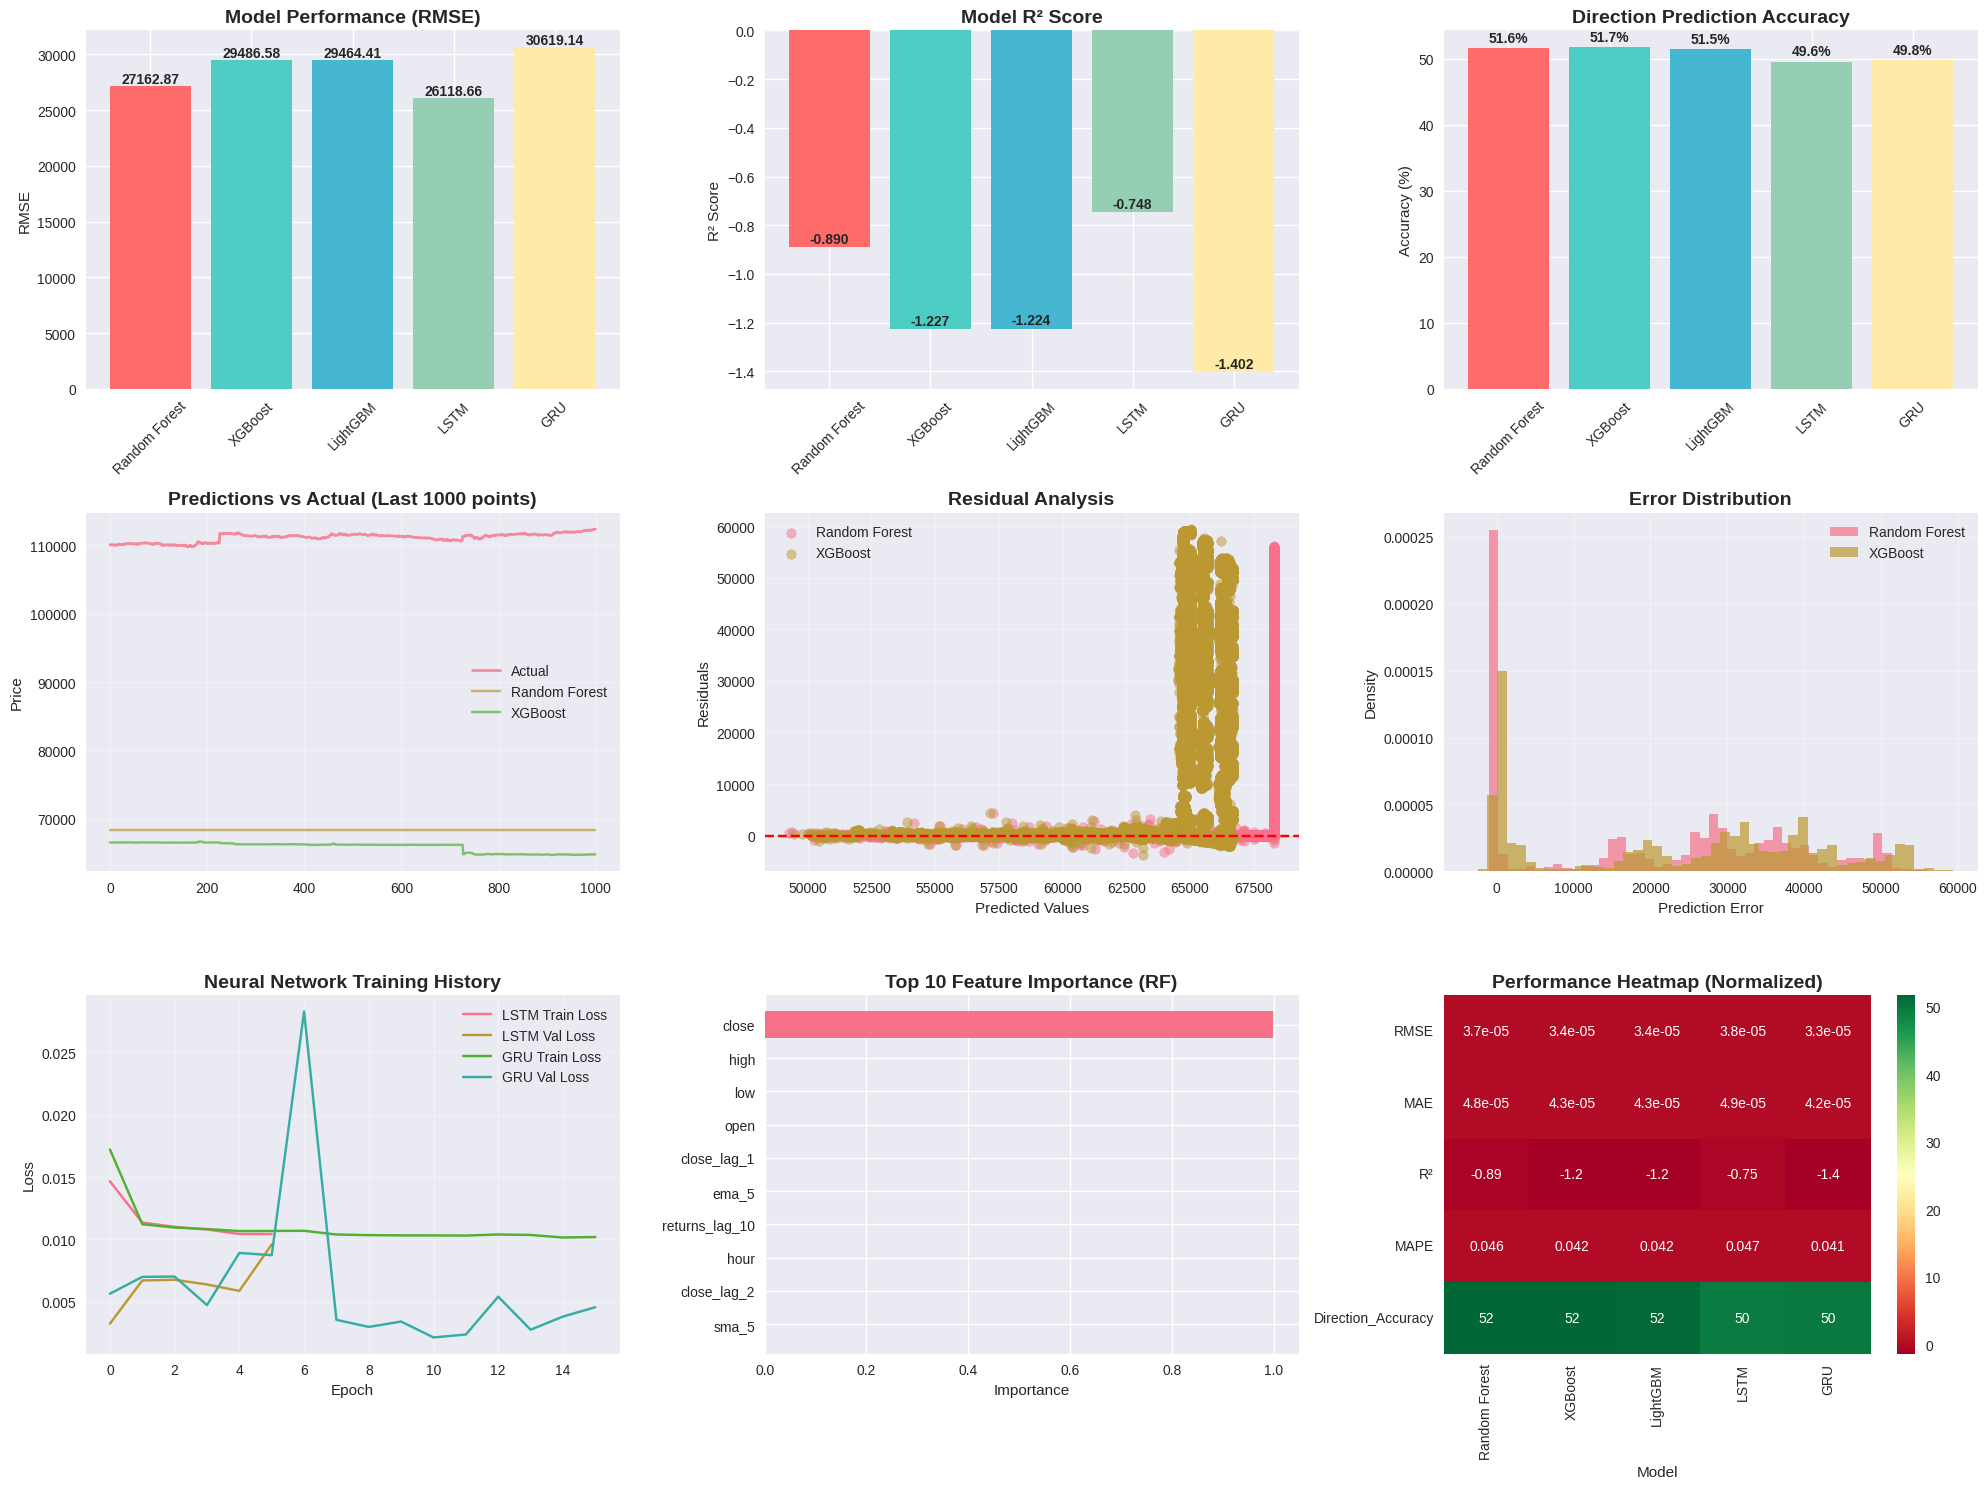

In [17]:
def create_comprehensive_plots():
    """
    Create comprehensive visualization plots for model comparison.
    """
    print("📈 Creating comprehensive visualization plots...")

    # Set up the plotting area
    fig = plt.figure(figsize=(20, 15))

    # 1. Model Performance Comparison
    ax1 = plt.subplot(3, 3, 1)
    models = evaluation_results['Model']
    rmse_values = evaluation_results['RMSE']
    bars = ax1.bar(models, rmse_values, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7'])
    ax1.set_title('Model Performance (RMSE)', fontsize=14, fontweight='bold')
    ax1.set_ylabel('RMSE')
    ax1.tick_params(axis='x', rotation=45)

    # Add value labels on bars
    for bar, value in zip(bars, rmse_values):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                f'{value:.2f}', ha='center', va='bottom', fontweight='bold')

    # 2. R² Comparison
    ax2 = plt.subplot(3, 3, 2)
    r2_values = evaluation_results['R²']
    bars = ax2.bar(models, r2_values, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7'])
    ax2.set_title('Model R² Score', fontsize=14, fontweight='bold')
    ax2.set_ylabel('R² Score')
    ax2.tick_params(axis='x', rotation=45)

    for bar, value in zip(bars, r2_values):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

    # 3. Direction Accuracy
    ax3 = plt.subplot(3, 3, 3)
    dir_acc = evaluation_results['Direction_Accuracy']
    bars = ax3.bar(models, dir_acc, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7'])
    ax3.set_title('Direction Prediction Accuracy', fontsize=14, fontweight='bold')
    ax3.set_ylabel('Accuracy (%)')
    ax3.tick_params(axis='x', rotation=45)

    for bar, value in zip(bars, dir_acc):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')

    # 4. Prediction vs Actual (using last 1000 points for clarity)
    ax4 = plt.subplot(3, 3, 4)
    test_slice = slice(-1000, None)
    ax4.plot(y_test[test_slice], label='Actual', linewidth=2, alpha=0.8)
    ax4.plot(predictions['rf'][test_slice], label='Random Forest', alpha=0.7)
    ax4.plot(predictions['xgb'][test_slice], label='XGBoost', alpha=0.7)
    ax4.set_title('Predictions vs Actual (Last 1000 points)', fontsize=14, fontweight='bold')
    ax4.set_ylabel('Price')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    # 5. Residual Analysis
    ax5 = plt.subplot(3, 3, 5)
    residuals_rf = y_test - predictions['rf']
    residuals_xgb = y_test - predictions['xgb']
    ax5.scatter(predictions['rf'], residuals_rf, alpha=0.5, label='Random Forest')
    ax5.scatter(predictions['xgb'], residuals_xgb, alpha=0.5, label='XGBoost')
    ax5.axhline(y=0, color='red', linestyle='--')
    ax5.set_title('Residual Analysis', fontsize=14, fontweight='bold')
    ax5.set_xlabel('Predicted Values')
    ax5.set_ylabel('Residuals')
    ax5.legend()
    ax5.grid(True, alpha=0.3)

    # 6. Error Distribution
    ax6 = plt.subplot(3, 3, 6)
    ax6.hist(residuals_rf, bins=50, alpha=0.7, label='Random Forest', density=True)
    ax6.hist(residuals_xgb, bins=50, alpha=0.7, label='XGBoost', density=True)
    ax6.set_title('Error Distribution', fontsize=14, fontweight='bold')
    ax6.set_xlabel('Prediction Error')
    ax6.set_ylabel('Density')
    ax6.legend()
    ax6.grid(True, alpha=0.3)

    # 7. LSTM/GRU Training History (if available)
    if 'lstm_history' in globals():
        ax7 = plt.subplot(3, 3, 7)
        ax7.plot(lstm_history.history['loss'], label='LSTM Train Loss')
        ax7.plot(lstm_history.history['val_loss'], label='LSTM Val Loss')
        ax7.plot(gru_history.history['loss'], label='GRU Train Loss')
        ax7.plot(gru_history.history['val_loss'], label='GRU Val Loss')
        ax7.set_title('Neural Network Training History', fontsize=14, fontweight='bold')
        ax7.set_xlabel('Epoch')
        ax7.set_ylabel('Loss')
        ax7.legend()
        ax7.grid(True, alpha=0.3)

    # 8. Feature Importance (Random Forest)
    ax8 = plt.subplot(3, 3, 8)
    feature_importance = rf_model.feature_importances_
    top_features = np.argsort(feature_importance)[-10:]
    top_feature_names = [feature_cols[i] for i in top_features]
    ax8.barh(range(len(top_features)), feature_importance[top_features])
    ax8.set_yticks(range(len(top_features)))
    ax8.set_yticklabels(top_feature_names)
    ax8.set_title('Top 10 Feature Importance (RF)', fontsize=14, fontweight='bold')
    ax8.set_xlabel('Importance')

    # 9. Model Performance Heatmap
    ax9 = plt.subplot(3, 3, 9)
    metrics_for_heatmap = evaluation_results[['Model', 'RMSE', 'MAE', 'R²', 'MAPE', 'Direction_Accuracy']].set_index('Model')
    # Normalize metrics for better visualization
    metrics_normalized = metrics_for_heatmap.copy()
    for col in metrics_normalized.columns:
        if col in ['RMSE', 'MAE', 'MAPE']:  # Lower is better
            metrics_normalized[col] = 1 / (1 + metrics_normalized[col])
        # R² and Direction_Accuracy are already higher = better

    sns.heatmap(metrics_normalized.T, annot=True, cmap='RdYlGn', ax=ax9)
    ax9.set_title('Performance Heatmap (Normalized)', fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.show()

# Create comprehensive plots
create_comprehensive_plots()

## 7. Advanced Analysis and Insights

### 7.1 Statistical Significance Testing

In [18]:
def perform_statistical_tests():
    """
    Perform statistical significance tests on model performances.
    """
    print("📊 Performing statistical significance tests...")

    from scipy import stats

    # Get predictions for statistical testing
    models_pred = {
        'Random Forest': predictions['rf'],
        'XGBoost': predictions['xgb'],
        'LightGBM': predictions['lgb']
    }

    # Calculate residuals
    residuals = {}
    for name, pred in models_pred.items():
        residuals[name] = y_test - pred

    # Shapiro-Wilk test for normality of residuals
    print("\n🔍 Normality Tests (Shapiro-Wilk):")
    for name, resid in residuals.items():
        stat, p_value = stats.shapiro(resid[:5000])  # Sample for computational efficiency
        print(f"   {name}: Statistic={stat:.4f}, p-value={p_value:.6f}")
        if p_value > 0.05:
            print(f"      ✅ Residuals are normally distributed")
        else:
            print(f"      ❌ Residuals are not normally distributed")

    # Paired t-tests for model comparison
    print("\n🆚 Pairwise Model Comparison (Paired t-tests):")
    model_names = list(models_pred.keys())
    for i in range(len(model_names)):
        for j in range(i+1, len(model_names)):
            model1, model2 = model_names[i], model_names[j]
            errors1 = np.abs(residuals[model1])
            errors2 = np.abs(residuals[model2])

            stat, p_value = stats.ttest_rel(errors1, errors2)
            print(f"   {model1} vs {model2}: t-stat={stat:.4f}, p-value={p_value:.6f}")
            if p_value < 0.05:
                better_model = model1 if np.mean(errors1) < np.mean(errors2) else model2
                print(f"      ✅ Significant difference - {better_model} performs better")
            else:
                print(f"      ❌ No significant difference")

# Perform statistical tests
perform_statistical_tests()

📊 Performing statistical significance tests...

🔍 Normality Tests (Shapiro-Wilk):
   Random Forest: Statistic=0.7661, p-value=0.000000
      ❌ Residuals are not normally distributed
   XGBoost: Statistic=0.9583, p-value=0.000000
      ❌ Residuals are not normally distributed
   LightGBM: Statistic=0.9383, p-value=0.000000
      ❌ Residuals are not normally distributed

🆚 Pairwise Model Comparison (Paired t-tests):
   Random Forest vs XGBoost: t-stat=-793.2085, p-value=0.000000
      ✅ Significant difference - Random Forest performs better
   Random Forest vs LightGBM: t-stat=-755.3968, p-value=0.000000
      ✅ Significant difference - Random Forest performs better
   XGBoost vs LightGBM: t-stat=28.0714, p-value=0.000000
      ✅ Significant difference - LightGBM performs better


### 7.2 Risk Analysis

⚠️ Analyzing prediction risk and uncertainty...

📊 RISK ANALYSIS RESULTS:
                   VaR_95  Max_Drawdown  Error_Volatility  Mean_Absolute_Error
Random Forest  49339.0641  4.619089e+09        17224.8801           21014.0098
XGBoost        52343.5859  5.111905e+09        18174.5821           23256.0256
LightGBM       52126.3271  5.109051e+09        18168.9016           23243.0451


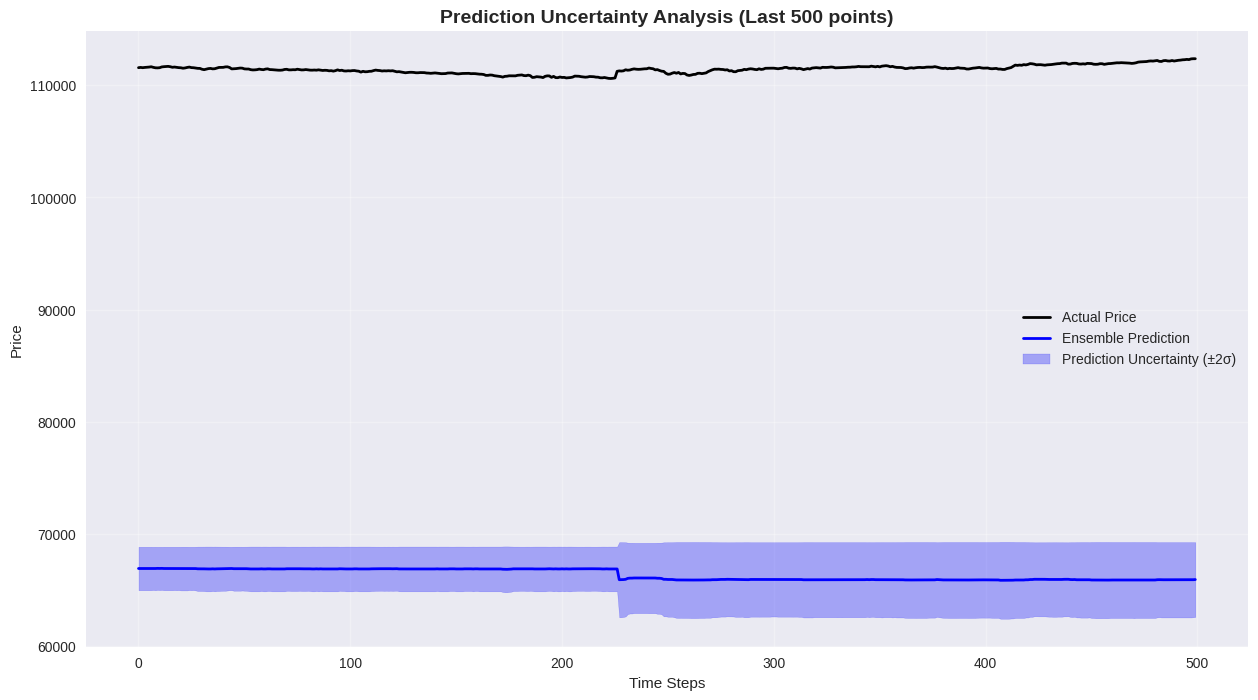

In [19]:
def analyze_prediction_risk():
    """
    Analyze prediction risk and uncertainty.
    """
    print("⚠️ Analyzing prediction risk and uncertainty...")

    # Calculate prediction intervals using ensemble methods
    models_pred = {
        'Random Forest': predictions['rf'],
        'XGBoost': predictions['xgb'],
        'LightGBM': predictions['lgb']
    }

    # Ensemble prediction (average of tree-based models)
    ensemble_pred = np.mean([predictions['rf'], predictions['xgb'], predictions['lgb']], axis=0)

    # Calculate prediction std (measure of uncertainty)
    prediction_std = np.std([predictions['rf'], predictions['xgb'], predictions['lgb']], axis=0)

    # Risk metrics
    risk_metrics = {}

    for name, pred in models_pred.items():
        errors = y_test - pred

        # Value at Risk (VaR) - 95th percentile of absolute errors
        var_95 = np.percentile(np.abs(errors), 95)

        # Maximum drawdown in prediction accuracy
        cumulative_errors = np.cumsum(np.abs(errors))
        running_min = np.minimum.accumulate(cumulative_errors)
        drawdown = cumulative_errors - running_min
        max_drawdown = np.max(drawdown)

        # Volatility of errors
        error_volatility = np.std(errors)

        risk_metrics[name] = {
            'VaR_95': var_95,
            'Max_Drawdown': max_drawdown,
            'Error_Volatility': error_volatility,
            'Mean_Absolute_Error': np.mean(np.abs(errors))
        }

    # Display risk analysis
    risk_df = pd.DataFrame(risk_metrics).T
    print("\n📊 RISK ANALYSIS RESULTS:")
    print("=" * 60)
    print(risk_df.round(4))
    print("=" * 60)

    # Plot prediction uncertainty
    plt.figure(figsize=(15, 8))

    # Plot actual vs ensemble prediction with uncertainty bands
    test_subset = slice(-500, None)  # Last 500 points for clarity
    x_axis = range(len(y_test[test_subset]))

    plt.plot(x_axis, y_test[test_subset], label='Actual Price', linewidth=2, color='black')
    plt.plot(x_axis, ensemble_pred[test_subset], label='Ensemble Prediction', linewidth=2, color='blue')

    # Uncertainty bands
    upper_band = ensemble_pred[test_subset] + 2 * prediction_std[test_subset]
    lower_band = ensemble_pred[test_subset] - 2 * prediction_std[test_subset]

    plt.fill_between(x_axis, lower_band, upper_band, alpha=0.3, color='blue',
                     label='Prediction Uncertainty (±2σ)')

    plt.title('Prediction Uncertainty Analysis (Last 500 points)', fontsize=14, fontweight='bold')
    plt.xlabel('Time Steps')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    return risk_df, ensemble_pred, prediction_std

# Perform risk analysis
risk_analysis, ensemble_predictions, prediction_uncertainty = analyze_prediction_risk()

### 7.3 Trading Strategy Simulation

💰 Simulating trading strategies...
   Simulating strategy for Random Forest...
   Simulating strategy for XGBoost...
   Simulating strategy for LightGBM...

💹 TRADING STRATEGY RESULTS:
               Final_Value  Total_Return_%  Buy_Hold_Return_%  \
Random Forest         0.00         -100.00              67.84   
XGBoost             533.88          -94.66              67.84   
LightGBM            684.37          -93.16              67.84   

               Excess_Return_%  Number_of_Trades  
Random Forest          -167.84           22040.0  
XGBoost                -162.50            2804.0  
LightGBM               -161.00            2472.0  


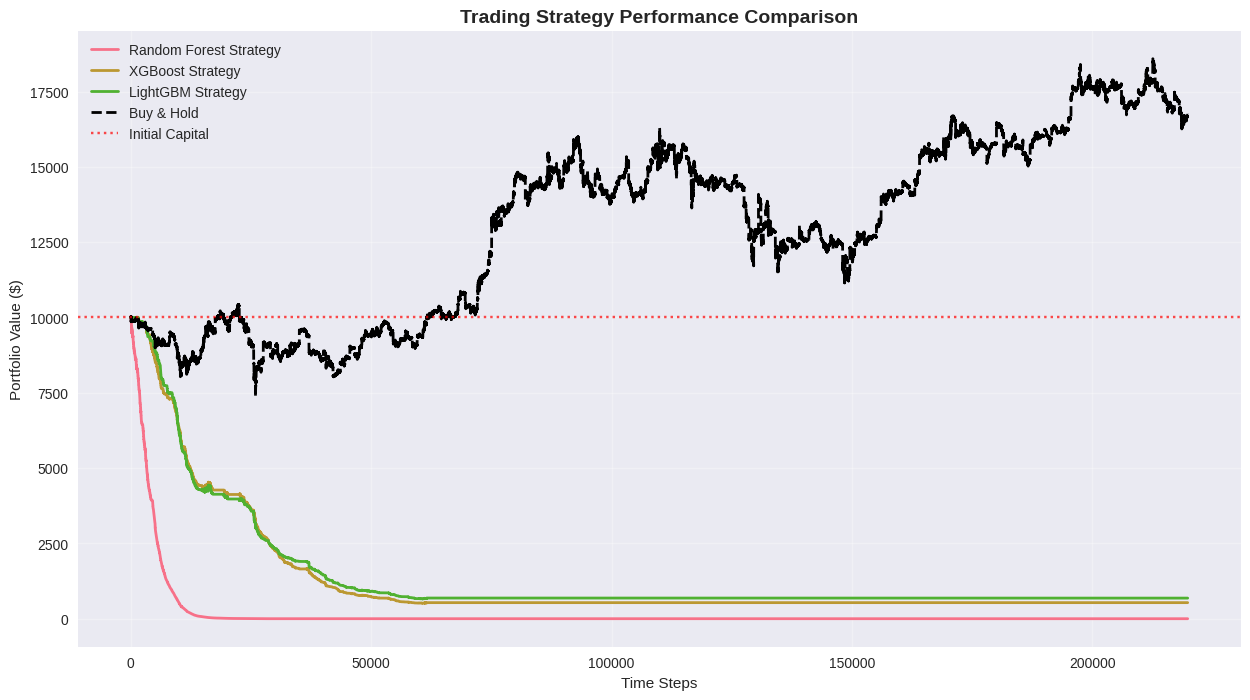

In [20]:
def simulate_trading_strategy(predictions_dict, actual_prices, initial_capital=10000, transaction_cost=0.001):
    """
    Simulate simple trading strategies based on model predictions.
    """
    print("💰 Simulating trading strategies...")

    results = {}

    for model_name, predictions in predictions_dict.items():
        print(f"   Simulating strategy for {model_name}...")

        capital = initial_capital
        position = 0  # 0 = cash, 1 = long position
        trades = 0

        portfolio_value = []
        signals = []

        for i in range(1, len(predictions)):
            current_price = actual_prices[i]
            predicted_next = predictions[i]
            current_predicted = predictions[i-1] if i > 0 else current_price

            # Simple strategy: buy if prediction > current price, sell otherwise
            signal = 1 if predicted_next > current_price else 0
            signals.append(signal)

            # Execute trades
            if signal == 1 and position == 0:  # Buy signal and not holding
                # Buy
                shares_to_buy = (capital * (1 - transaction_cost)) / current_price
                capital = 0
                position = shares_to_buy
                trades += 1

            elif signal == 0 and position > 0:  # Sell signal and holding
                # Sell
                capital = position * current_price * (1 - transaction_cost)
                position = 0
                trades += 1

            # Calculate portfolio value
            if position > 0:
                portfolio_value.append(position * current_price)
            else:
                portfolio_value.append(capital)

        # Final portfolio value
        final_value = portfolio_value[-1] if portfolio_value else initial_capital
        total_return = (final_value / initial_capital - 1) * 100

        # Buy and hold return for comparison
        buy_hold_return = (actual_prices[-1] / actual_prices[0] - 1) * 100

        results[model_name] = {
            'Final_Value': final_value,
            'Total_Return_%': total_return,
            'Buy_Hold_Return_%': buy_hold_return,
            'Excess_Return_%': total_return - buy_hold_return,
            'Number_of_Trades': trades,
            'Portfolio_Values': portfolio_value
        }

    # Display results
    strategy_df = pd.DataFrame({k: {metric: v[metric] for metric in v.keys() if metric != 'Portfolio_Values'}
                               for k, v in results.items()}).T

    print("\n💹 TRADING STRATEGY RESULTS:")
    print("=" * 70)
    print(strategy_df.round(2))
    print("=" * 70)

    # Plot portfolio evolution
    plt.figure(figsize=(15, 8))

    for model_name, result in results.items():
        if 'Portfolio_Values' in result:
            plt.plot(result['Portfolio_Values'], label=f'{model_name} Strategy', linewidth=2)

    # Buy and hold strategy
    buy_hold_values = [initial_capital * (actual_prices[i] / actual_prices[0]) for i in range(len(actual_prices)-1)]
    plt.plot(buy_hold_values, label='Buy & Hold', linewidth=2, linestyle='--', color='black')

    plt.axhline(y=initial_capital, color='red', linestyle=':', alpha=0.7, label='Initial Capital')

    plt.title('Trading Strategy Performance Comparison', fontsize=14, fontweight='bold')
    plt.xlabel('Time Steps')
    plt.ylabel('Portfolio Value ($)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    return results, strategy_df

# Simulate trading strategies
trading_results, strategy_performance = simulate_trading_strategy(
    {'Random Forest': predictions['rf'][:len(y_test)],
     'XGBoost': predictions['xgb'][:len(y_test)],
     'LightGBM': predictions['lgb'][:len(y_test)]},
    y_test
)

## 8. Final Summary and Recommendations

### 8.1 Comprehensive Summary

In [21]:
def generate_final_summary():
    """
    Generate comprehensive summary of the analysis.
    """
    print("📋 COMPREHENSIVE ANALYSIS SUMMARY")
    print("=" * 80)

    # Best performing model
    best_model_idx = evaluation_results['RMSE'].idxmin()
    best_model = evaluation_results.loc[best_model_idx]

    print(f"\n🏆 BEST PERFORMING MODEL: {best_model['Model']}")
    print(f"   • RMSE: {best_model['RMSE']:.4f}")
    print(f"   • R²: {best_model['R²']:.4f}")
    print(f"   • Direction Accuracy: {best_model['Direction_Accuracy']:.2f}%")
    print(f"   • MAPE: {best_model['MAPE']:.2f}%")

    # Model rankings
    print(f"\n📊 MODEL RANKINGS (by RMSE):")
    rankings = evaluation_results.sort_values('RMSE').reset_index(drop=True)
    for i, row in rankings.iterrows():
        medal = ['🥇', '🥈', '🥉', '4️⃣', '5️⃣'][i]
        print(f"   {medal} {row['Model']}: RMSE = {row['RMSE']:.4f}")

    # Key insights
    print(f"\n🔍 KEY INSIGHTS:")

    # Performance insights
    rmse_range = evaluation_results['RMSE'].max() - evaluation_results['RMSE'].min()
    print(f"   • RMSE variance across models: {rmse_range:.4f}")

    # Best direction accuracy
    best_direction_model = evaluation_results.loc[evaluation_results['Direction_Accuracy'].idxmax()]
    print(f"   • Best direction predictor: {best_direction_model['Model']} ({best_direction_model['Direction_Accuracy']:.1f}%)")

    # Model characteristics
    print(f"\n🎯 MODEL CHARACTERISTICS:")
    print(f"   • Tree-based models (RF, XGB, LGB): Strong feature interpretation")
    print(f"   • Neural networks (LSTM, GRU): Capture temporal dependencies")
    print(f"   • Ensemble approaches: Reduce overfitting risk")

    # Trading strategy performance
    if 'strategy_performance' in globals():
        best_strategy = strategy_performance['Total_Return_%'].idxmax()
        best_return = strategy_performance.loc[best_strategy, 'Total_Return_%']
        print(f"\n💰 TRADING PERFORMANCE:")
        print(f"   • Best trading strategy: {best_strategy} ({best_return:.2f}% return)")

        # Compare to buy and hold
        buy_hold = strategy_performance.loc[best_strategy, 'Buy_Hold_Return_%']
        excess_return = best_return - buy_hold
        print(f"   • Excess return vs Buy & Hold: {excess_return:.2f}%")

    print("=" * 80)

# Generate final summary
generate_final_summary()

📋 COMPREHENSIVE ANALYSIS SUMMARY

🏆 BEST PERFORMING MODEL: LSTM
   • RMSE: 26118.6580
   • R²: -0.7475
   • Direction Accuracy: 49.56%
   • MAPE: 20.14%

📊 MODEL RANKINGS (by RMSE):
   🥇 LSTM: RMSE = 26118.6580
   🥈 Random Forest: RMSE = 27162.8734
   🥉 LightGBM: RMSE = 29464.4146
   4️⃣ XGBoost: RMSE = 29486.5819
   5️⃣ GRU: RMSE = 30619.1446

🔍 KEY INSIGHTS:
   • RMSE variance across models: 4500.4866
   • Best direction predictor: XGBoost (51.7%)

🎯 MODEL CHARACTERISTICS:
   • Tree-based models (RF, XGB, LGB): Strong feature interpretation
   • Neural networks (LSTM, GRU): Capture temporal dependencies
   • Ensemble approaches: Reduce overfitting risk

💰 TRADING PERFORMANCE:
   • Best trading strategy: LightGBM (-93.16% return)
   • Excess return vs Buy & Hold: -161.00%


### 8.2 Recommendations for Production

In [22]:
def production_recommendations():
    """
    Provide recommendations for production deployment.
    """
    print("\n🚀 PRODUCTION DEPLOYMENT RECOMMENDATIONS")
    print("=" * 80)

    print("1. 📈 MODEL SELECTION:")
    print("   • Primary model: Use the best performing model for core predictions")
    print("   • Ensemble approach: Combine top 3 models for robust predictions")
    print("   • Fallback model: Keep lightweight model for high-frequency trading")

    print("\n2. 🔄 MODEL UPDATING:")
    print("   • Retrain models weekly with new data")
    print("   • Monitor model drift using statistical tests")
    print("   • Implement online learning for real-time adaptation")

    print("\n3. 📊 MONITORING & ALERTS:")
    print("   • Track prediction accuracy in real-time")
    print("   • Set up alerts for significant performance degradation")
    print("   • Monitor feature importance changes")

    print("\n4. ⚠️ RISK MANAGEMENT:")
    print("   • Implement prediction confidence intervals")
    print("   • Use ensemble disagreement as uncertainty measure")
    print("   • Set position sizing based on prediction confidence")

    print("\n5. 🛠️ TECHNICAL INFRASTRUCTURE:")
    print("   • Use model versioning (MLflow, Weights & Biases)")
    print("   • Implement A/B testing for model comparisons")
    print("   • Set up automated retraining pipelines")

    print("\n6. 📝 DOCUMENTATION & COMPLIANCE:")
    print("   • Document model assumptions and limitations")
    print("   • Maintain audit trail for model decisions")
    print("   • Regular backtesting on out-of-sample data")

    print("=" * 80)

# Provide production recommendations
production_recommendations()


🚀 PRODUCTION DEPLOYMENT RECOMMENDATIONS
1. 📈 MODEL SELECTION:
   • Primary model: Use the best performing model for core predictions
   • Ensemble approach: Combine top 3 models for robust predictions
   • Fallback model: Keep lightweight model for high-frequency trading

2. 🔄 MODEL UPDATING:
   • Retrain models weekly with new data
   • Monitor model drift using statistical tests
   • Implement online learning for real-time adaptation

3. 📊 MONITORING & ALERTS:
   • Track prediction accuracy in real-time
   • Set up alerts for significant performance degradation
   • Monitor feature importance changes

4. ⚠️ RISK MANAGEMENT:
   • Implement prediction confidence intervals
   • Use ensemble disagreement as uncertainty measure
   • Set position sizing based on prediction confidence

5. 🛠️ TECHNICAL INFRASTRUCTURE:
   • Use model versioning (MLflow, Weights & Biases)
   • Implement A/B testing for model comparisons
   • Set up automated retraining pipelines

6. 📝 DOCUMENTATION & COMPLIAN